# Models Comparison for TinyML

In [11]:
# Load libraries
import numpy as np
from numpy import arange
import pickle
from pandas import read_csv
#
import matplotlib.pyplot as plt

#
import pandas as pd
from pandas import read_csv

from sklearn.metrics import confusion_matrix,  classification_report, f1_score
from sklearn.model_selection import train_test_split, KFold,StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline

from keras.models import Sequential, Model 
from keras.layers import Dense, Input, concatenate, Activation, Dropout
from keras.optimizers import Adam
from tensorflow.keras import layers

import tensorflow
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from micromlgen import port
import tinymlgen as tiny

import warnings
import seaborn as sbs
import sys

warnings.filterwarnings('ignore')

In [12]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tensorflow.random.set_seed(RANDOM_SEED)
np.set_printoptions(threshold=sys.maxsize)

In [21]:
data = ['../data/X-intensity.pkl', '../data/X-all.pkl', '../data/X-10-25.pkl', '../data/X-1-2.pkl', '../data/X-25_50-50_25.pkl']
labels = ['../data/y-intensity.pkl', '../data/y-all.pkl', '../data/y-10-25.pkl', '../data/y-1-2.pkl', '../data/y-25_50-50_25.pkl']
choosenIndex = 0
tasks = ['intensity', 'all','10-25','1-2', '25-50']
with open(data[choosenIndex], 'rb') as f:
    X = pickle.load(f)

with open(labels[choosenIndex], 'rb') as f:
    y = pickle.load(f)

In [22]:
if choosenIndex == 1:
    X = X[165:-13]
    y = y[165:-13]
if choosenIndex == 2:
    X = X[146:-13]
    y = y[146:-13]
if choosenIndex == 3:
    X = X[101:-13]
    y = y[101:-13]

In [23]:
print(X.shape)

(3900, 60)


In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED)
uniques = np.unique(y)

In [25]:
print(X_test.shape)
print(X_test)

(780, 60)
[[-0.15  0.06  0.91 -0.04 -0.06  0.9   0.   -0.07  0.91  0.15 -0.15  1.03
   0.17 -0.16  1.06  0.11 -0.12  1.05 -0.11  0.07  1.   -0.13  0.05  0.96
  -0.12  0.05  0.94 -0.03  0.04  0.93  0.01  0.06  0.97 -0.    0.08  1.04
  -0.03  0.07  1.06 -0.09  0.08  1.02 -0.13  0.04  0.95 -0.1  -0.    0.93
  -0.04 -0.03  0.92  0.16 -0.16  1.01  0.17 -0.15  1.03 -0.08  0.08  1.02]
 [-0.13  0.05  0.91  0.17 -0.2   0.97  0.18 -0.16  1.03  0.16 -0.13  1.05
  -0.08  0.08  1.03 -0.11  0.06  1.01 -0.1   0.04  0.9  -0.07  0.03  0.89
  -0.02  0.02  0.91 -0.02  0.13  1.01 -0.01  0.12  1.03 -0.01  0.11  1.05
  -0.15  0.12  1.02 -0.16  0.08  1.    0.03 -0.21  0.89  0.08 -0.19  0.9
   0.15 -0.21  0.93  0.06  0.02  1.05  0.    0.07  1.05 -0.04  0.06  1.04]
 [-0.12  0.    0.97 -0.09 -0.05  0.94 -0.04 -0.07  0.95  0.16 -0.14  1.
   0.16 -0.15  1.03 -0.11  0.09  1.02 -0.12  0.07  1.   -0.13  0.05  0.97
  -0.03  0.02  0.93  0.01  0.07  0.95 -0.    0.08  1.   -0.04  0.08  1.05
  -0.09  0.07  1.03 -0.14  0.

## Model Spotting

In [26]:
# Test options and evaluation metric
num_folds = 10
seed = 42
scoring = 'f1_macro'


In [27]:
# Spot-Check Algorithms
models = []

#models.append(('XGB', XGBClassifier(random_state=seed)))
models.append(('GNB', GaussianNB(var_smoothing=2e-9)))
models.append(('LR',  LogisticRegression(random_state=seed)))
models.append(('CART' , DecisionTreeClassifier(random_state=seed)))
models.append(('SVC' , SVC(gamma=0.5, random_state=seed)))
models.append(('RF', RandomForestClassifier(random_state=seed, n_estimators = 50)))


In [28]:
results = []
names = []
for name, model in models:
    # Dividere dati in n = num_folds
    kf = StratifiedKFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = np.array([])
    for train_idx, test_idx, in kf.split(X_train, y_train):
        X_cross_train, y_cross_train = X_train[train_idx], y_train[train_idx]
        X_cross_test, y_cross_test = X_train[test_idx], y_train[test_idx]
        model.fit(X_cross_train, y_cross_train)  
        y_pred = model.predict(X_cross_test)
        f1s = f1_score(y_cross_test, y_pred, average="weighted")
        cv_results = np.append(cv_results, [f1s])
    results.append(cv_results)
    names.append(name)
    #msg = "%s - %f - %f" % (name, cv_results.mean(), cv_results.std())
    msg = "{} - {:.2f} {:.2f}".format(name, cv_results.mean(), cv_results.std()).replace('.', ',')
    print(msg)

GNB - 0,78 0,03
LR - 0,48 0,02
CART - 0,78 0,03
SVC - 0,96 0,01
RF - 0,99 0,01


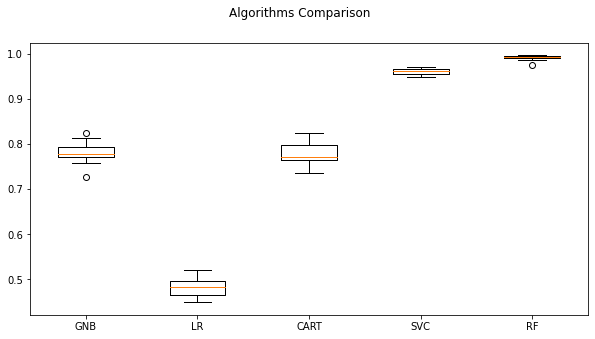

In [29]:
# Compare Algorithms
fig = plt.figure(figsize=(10,5))
fig.suptitle('Algorithms Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

# Valutazione dei modelli sul Test Set

In [30]:

def classification_report_csv(report, model_name):
    report_data = []
    lines = report.split('\n')
    index = 0
    row = lines[-4].split('    ')
    accuracy = row[-2]
    for line in lines[2:-5]:
        row = {}
        row_data = line.split('      ')
        row['class'] = uniques[index]
        row['precision'] = float(row_data[2]) 
        row['recall'] = float(row_data[3]) 
        row['f1_score'] = float(row_data[4])
        row['accuracy'] = accuracy
        report_data.append(row)
        index += 1
    dataframe = pd.DataFrame.from_dict(report_data)
    dataframe.to_csv(tasks[choosenIndex]+ '/classificationReports'+ '/'+'classification_report' + model_name +  '.csv', index = False)
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED)

for name, model in models:
    model.fit(X_train,  y_train)
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    print(f"Model {name}: ")
    report = classification_report(y_test, pred_test)
    print(report)
    classification_report_csv(report, name)
    print("-------------------------------------------------------------")

Model GNB: 
              precision    recall  f1-score   support

           0       0.71      0.68      0.70       156
           1       0.69      0.72      0.71       156
           2       0.99      0.97      0.98       156
           3       0.84      0.76      0.80       156
           4       0.79      0.87      0.83       156

    accuracy                           0.80       780
   macro avg       0.80      0.80      0.80       780
weighted avg       0.80      0.80      0.80       780

-------------------------------------------------------------
Model LR: 
              precision    recall  f1-score   support

           0       0.38      0.30      0.34       156
           1       0.38      0.51      0.43       156
           2       0.86      0.98      0.92       156
           3       0.18      0.08      0.11       156
           4       0.55      0.71      0.62       156

    accuracy                           0.52       780
   macro avg       0.47      0.52      0.48   

# Neural Network

In [40]:
def getNetwork():
    n = 50
    model = Sequential(name="Sequential-NN")
    model.add(layers.Dense(X.shape[1], activation='relu', input_shape=(X.shape[1],)))
    model.add(layers.Dense(np.unique(y).size * n, activation='relu'))
    model.add(layers.Dense(np.unique(y).size, activation='softmax'))
    opt = Adam(learning_rate=0.0001)
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

# Cross-Validation NN

In [34]:
EPOCHS = 100
BATCH_SIZE = 10
num_folds = 10

kf = StratifiedKFold(n_splits=num_folds, random_state=seed, shuffle=True)
cv_results = np.array([])
for train_idx, test_idx, in kf.split(X_train, y_train):
    X_cross_train, y_cross_train = X_train[train_idx], y_train[train_idx]
    X_cross_test, y_cross_test = X_train[test_idx], y_train[test_idx]
    model = getNetwork()
    model.fit(X_cross_train, y_cross_train, epochs=EPOCHS, batch_size=BATCH_SIZE)  
    y_pred = model.predict(X_cross_test)
    predictions_categorical = np.argmax(y_pred, axis=1)
    f1s = f1_score(y_cross_test, predictions_categorical, average="weighted")
    cv_results = np.append(cv_results, [f1s])

print(f'Average score of Cross Validation: {cv_results.mean()}')

Model: "Sequential-NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 60)                3660      
_________________________________________________________________
dense_1 (Dense)              (None, 250)               15250     
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 1255      
Total params: 20,165
Trainable params: 20,165
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
281/281 [==============================] - 0s 387us/step - loss: 1.6053 - accuracy: 0.2393
Epoch 2/100
281/281 [==============================] - 0s 361us/step - loss: 1.5749 - accuracy: 0.3205
Epoch 3/100
281/281 [==============================] - 0s 368us/step - loss: 1.5354 - accuracy: 0.3672
Epoch 4/100
281/281 [==============================] - 0s 377us/step -

281/281 [==============================] - 0s 368us/step - loss: 0.3356 - accuracy: 0.8942
Epoch 73/100
281/281 [==============================] - 0s 372us/step - loss: 0.3288 - accuracy: 0.8953
Epoch 74/100
281/281 [==============================] - 0s 366us/step - loss: 0.3238 - accuracy: 0.8964
Epoch 75/100
281/281 [==============================] - 0s 376us/step - loss: 0.3155 - accuracy: 0.9021
Epoch 76/100
281/281 [==============================] - 0s 380us/step - loss: 0.3103 - accuracy: 0.9028
Epoch 77/100
281/281 [==============================] - 0s 369us/step - loss: 0.3046 - accuracy: 0.9085
Epoch 78/100
281/281 [==============================] - 0s 374us/step - loss: 0.2984 - accuracy: 0.9074
Epoch 79/100
281/281 [==============================] - 0s 365us/step - loss: 0.2929 - accuracy: 0.9120
Epoch 80/100
281/281 [==============================] - 0s 371us/step - loss: 0.2878 - accuracy: 0.9074
Epoch 81/100
281/281 [==============================] - 0s 379us/step - loss:

281/281 [==============================] - 0s 378us/step - loss: 0.4473 - accuracy: 0.8722
Epoch 44/100
281/281 [==============================] - 0s 375us/step - loss: 0.4336 - accuracy: 0.8811
Epoch 45/100
281/281 [==============================] - 0s 374us/step - loss: 0.4213 - accuracy: 0.8850
Epoch 46/100
281/281 [==============================] - 0s 376us/step - loss: 0.4092 - accuracy: 0.8857
Epoch 47/100
281/281 [==============================] - 0s 369us/step - loss: 0.3982 - accuracy: 0.8875
Epoch 48/100
281/281 [==============================] - 0s 368us/step - loss: 0.3857 - accuracy: 0.8935
Epoch 49/100
281/281 [==============================] - 0s 373us/step - loss: 0.3771 - accuracy: 0.8985
Epoch 50/100
281/281 [==============================] - 0s 369us/step - loss: 0.3649 - accuracy: 0.8974
Epoch 51/100
281/281 [==============================] - 0s 376us/step - loss: 0.3567 - accuracy: 0.9003
Epoch 52/100
281/281 [==============================] - 0s 372us/step - loss:

281/281 [==============================] - 0s 375us/step - loss: 0.9937 - accuracy: 0.6375
Epoch 15/100
281/281 [==============================] - 0s 377us/step - loss: 0.9651 - accuracy: 0.6478
Epoch 16/100
281/281 [==============================] - 0s 370us/step - loss: 0.9362 - accuracy: 0.6667
Epoch 17/100
281/281 [==============================] - 0s 372us/step - loss: 0.9103 - accuracy: 0.6774
Epoch 18/100
281/281 [==============================] - 0s 370us/step - loss: 0.8862 - accuracy: 0.6841
Epoch 19/100
281/281 [==============================] - 0s 382us/step - loss: 0.8605 - accuracy: 0.6937
Epoch 20/100
281/281 [==============================] - 0s 382us/step - loss: 0.8373 - accuracy: 0.6944
Epoch 21/100
281/281 [==============================] - 0s 379us/step - loss: 0.8160 - accuracy: 0.7105
Epoch 22/100
281/281 [==============================] - 0s 372us/step - loss: 0.7941 - accuracy: 0.7112
Epoch 23/100
281/281 [==============================] - 0s 397us/step - loss:

281/281 [==============================] - 0s 381us/step - loss: 0.1900 - accuracy: 0.9437
Epoch 93/100
281/281 [==============================] - 0s 373us/step - loss: 0.1875 - accuracy: 0.9476
Epoch 94/100
281/281 [==============================] - 0s 372us/step - loss: 0.1851 - accuracy: 0.9455
Epoch 95/100
281/281 [==============================] - 0s 376us/step - loss: 0.1832 - accuracy: 0.9469
Epoch 96/100
281/281 [==============================] - 0s 376us/step - loss: 0.1789 - accuracy: 0.9484
Epoch 97/100
281/281 [==============================] - 0s 374us/step - loss: 0.1797 - accuracy: 0.9476
Epoch 98/100
281/281 [==============================] - 0s 367us/step - loss: 0.1743 - accuracy: 0.9476
Epoch 99/100
281/281 [==============================] - 0s 372us/step - loss: 0.1725 - accuracy: 0.9523
Epoch 100/100
281/281 [==============================] - 0s 377us/step - loss: 0.1707 - accuracy: 0.9526
Model: "Sequential-NN"
_____________________________________________________

281/281 [==============================] - 0s 372us/step - loss: 0.3249 - accuracy: 0.8989
Epoch 64/100
281/281 [==============================] - 0s 373us/step - loss: 0.3184 - accuracy: 0.9067
Epoch 65/100
281/281 [==============================] - 0s 374us/step - loss: 0.3112 - accuracy: 0.9071
Epoch 66/100
281/281 [==============================] - 0s 378us/step - loss: 0.3055 - accuracy: 0.9088
Epoch 67/100
281/281 [==============================] - 0s 375us/step - loss: 0.2974 - accuracy: 0.9184
Epoch 68/100
281/281 [==============================] - 0s 374us/step - loss: 0.2918 - accuracy: 0.9181
Epoch 69/100
281/281 [==============================] - 0s 369us/step - loss: 0.2882 - accuracy: 0.9202
Epoch 70/100
281/281 [==============================] - 0s 371us/step - loss: 0.2821 - accuracy: 0.9192
Epoch 71/100
281/281 [==============================] - 0s 373us/step - loss: 0.2762 - accuracy: 0.9181
Epoch 72/100
281/281 [==============================] - 0s 372us/step - loss:

281/281 [==============================] - 0s 373us/step - loss: 0.5815 - accuracy: 0.8123
Epoch 35/100
281/281 [==============================] - 0s 375us/step - loss: 0.5677 - accuracy: 0.8180
Epoch 36/100
281/281 [==============================] - 0s 377us/step - loss: 0.5566 - accuracy: 0.8202
Epoch 37/100
281/281 [==============================] - 0s 373us/step - loss: 0.5471 - accuracy: 0.8223
Epoch 38/100
281/281 [==============================] - 0s 372us/step - loss: 0.5370 - accuracy: 0.8276
Epoch 39/100
281/281 [==============================] - 0s 375us/step - loss: 0.5267 - accuracy: 0.8333
Epoch 40/100
281/281 [==============================] - 0s 375us/step - loss: 0.5165 - accuracy: 0.8340
Epoch 41/100
281/281 [==============================] - 0s 369us/step - loss: 0.5064 - accuracy: 0.8444
Epoch 42/100
281/281 [==============================] - 0s 375us/step - loss: 0.4971 - accuracy: 0.8433
Epoch 43/100
281/281 [==============================] - 0s 376us/step - loss:

281/281 [==============================] - 0s 371us/step - loss: 1.3804 - accuracy: 0.4487
Epoch 6/100
281/281 [==============================] - 0s 372us/step - loss: 1.3063 - accuracy: 0.4736
Epoch 7/100
281/281 [==============================] - 0s 383us/step - loss: 1.2416 - accuracy: 0.5231
Epoch 8/100
281/281 [==============================] - 0s 390us/step - loss: 1.1879 - accuracy: 0.5495
Epoch 9/100
281/281 [==============================] - 0s 377us/step - loss: 1.1427 - accuracy: 0.5776
Epoch 10/100
281/281 [==============================] - 0s 378us/step - loss: 1.1033 - accuracy: 0.5947
Epoch 11/100
281/281 [==============================] - 0s 379us/step - loss: 1.0703 - accuracy: 0.6157
Epoch 12/100
281/281 [==============================] - 0s 393us/step - loss: 1.0390 - accuracy: 0.6172
Epoch 13/100
281/281 [==============================] - 0s 374us/step - loss: 1.0097 - accuracy: 0.6407
Epoch 14/100
281/281 [==============================] - 0s 382us/step - loss: 0.9

Epoch 84/100
281/281 [==============================] - 0s 412us/step - loss: 0.1988 - accuracy: 0.9416
Epoch 85/100
281/281 [==============================] - 0s 408us/step - loss: 0.1958 - accuracy: 0.9416
Epoch 86/100
281/281 [==============================] - 0s 410us/step - loss: 0.1915 - accuracy: 0.9434
Epoch 87/100
281/281 [==============================] - 0s 407us/step - loss: 0.1894 - accuracy: 0.9430
Epoch 88/100
281/281 [==============================] - 0s 417us/step - loss: 0.1884 - accuracy: 0.9423
Epoch 89/100
281/281 [==============================] - 0s 415us/step - loss: 0.1849 - accuracy: 0.9444
Epoch 90/100
281/281 [==============================] - 0s 402us/step - loss: 0.1843 - accuracy: 0.9437
Epoch 91/100
281/281 [==============================] - 0s 404us/step - loss: 0.1813 - accuracy: 0.9494
Epoch 92/100
281/281 [==============================] - 0s 401us/step - loss: 0.1780 - accuracy: 0.9484
Epoch 93/100
281/281 [==============================] - 0s 410us

281/281 [==============================] - 0s 392us/step - loss: 0.3975 - accuracy: 0.8800
Epoch 56/100
281/281 [==============================] - 0s 389us/step - loss: 0.3872 - accuracy: 0.8828
Epoch 57/100
281/281 [==============================] - 0s 394us/step - loss: 0.3792 - accuracy: 0.8846
Epoch 58/100
281/281 [==============================] - 0s 407us/step - loss: 0.3696 - accuracy: 0.8828
Epoch 59/100
281/281 [==============================] - 0s 389us/step - loss: 0.3627 - accuracy: 0.8892
Epoch 60/100
281/281 [==============================] - 0s 408us/step - loss: 0.3567 - accuracy: 0.8900
Epoch 61/100
281/281 [==============================] - 0s 415us/step - loss: 0.3496 - accuracy: 0.8921
Epoch 62/100
281/281 [==============================] - 0s 394us/step - loss: 0.3421 - accuracy: 0.8946
Epoch 63/100
281/281 [==============================] - 0s 401us/step - loss: 0.3364 - accuracy: 0.8914
Epoch 64/100
281/281 [==============================] - 0s 400us/step - loss:

281/281 [==============================] - 0s 386us/step - loss: 0.7369 - accuracy: 0.7628
Epoch 27/100
281/281 [==============================] - 0s 392us/step - loss: 0.7189 - accuracy: 0.7742
Epoch 28/100
281/281 [==============================] - 0s 383us/step - loss: 0.6992 - accuracy: 0.7767
Epoch 29/100
281/281 [==============================] - 0s 387us/step - loss: 0.6828 - accuracy: 0.7785
Epoch 30/100
281/281 [==============================] - 0s 389us/step - loss: 0.6658 - accuracy: 0.7963
Epoch 31/100
281/281 [==============================] - 0s 384us/step - loss: 0.6503 - accuracy: 0.7974
Epoch 32/100
281/281 [==============================] - 0s 391us/step - loss: 0.6356 - accuracy: 0.8041
Epoch 33/100
281/281 [==============================] - 0s 389us/step - loss: 0.6188 - accuracy: 0.8091
Epoch 34/100
281/281 [==============================] - 0s 393us/step - loss: 0.6048 - accuracy: 0.8134
Epoch 35/100
281/281 [==============================] - 0s 388us/step - loss:

Epoch 1/100
281/281 [==============================] - 0s 382us/step - loss: 1.6057 - accuracy: 0.2436
Epoch 2/100
281/281 [==============================] - 0s 404us/step - loss: 1.5743 - accuracy: 0.3390
Epoch 3/100
281/281 [==============================] - 0s 408us/step - loss: 1.5350 - accuracy: 0.3693
Epoch 4/100
281/281 [==============================] - 0s 410us/step - loss: 1.4776 - accuracy: 0.4188
Epoch 5/100
281/281 [==============================] - 0s 409us/step - loss: 1.4064 - accuracy: 0.4537
Epoch 6/100
281/281 [==============================] - 0s 407us/step - loss: 1.3347 - accuracy: 0.4541
Epoch 7/100
281/281 [==============================] - 0s 408us/step - loss: 1.2691 - accuracy: 0.5078
Epoch 8/100
281/281 [==============================] - 0s 407us/step - loss: 1.2165 - accuracy: 0.5078
Epoch 9/100
281/281 [==============================] - 0s 406us/step - loss: 1.1750 - accuracy: 0.5381
Epoch 10/100
281/281 [==============================] - 0s 403us/step - l

281/281 [==============================] - 0s 423us/step - loss: 0.2846 - accuracy: 0.9060
Epoch 80/100
281/281 [==============================] - 0s 422us/step - loss: 0.2808 - accuracy: 0.9095
Epoch 81/100
281/281 [==============================] - 0s 409us/step - loss: 0.2757 - accuracy: 0.9110
Epoch 82/100
281/281 [==============================] - 0s 419us/step - loss: 0.2719 - accuracy: 0.9120
Epoch 83/100
281/281 [==============================] - 0s 428us/step - loss: 0.2687 - accuracy: 0.9110
Epoch 84/100
281/281 [==============================] - 0s 424us/step - loss: 0.2648 - accuracy: 0.9142
Epoch 85/100
281/281 [==============================] - 0s 420us/step - loss: 0.2626 - accuracy: 0.9145
Epoch 86/100
281/281 [==============================] - 0s 408us/step - loss: 0.2587 - accuracy: 0.9217
Epoch 87/100
281/281 [==============================] - 0s 431us/step - loss: 0.2529 - accuracy: 0.9163
Epoch 88/100
281/281 [==============================] - 0s 426us/step - loss:

281/281 [==============================] - 0s 425us/step - loss: 0.3014 - accuracy: 0.9088
Epoch 51/100
281/281 [==============================] - 0s 429us/step - loss: 0.2942 - accuracy: 0.9117
Epoch 52/100
281/281 [==============================] - 0s 428us/step - loss: 0.2877 - accuracy: 0.9138
Epoch 53/100
281/281 [==============================] - 0s 426us/step - loss: 0.2789 - accuracy: 0.9170
Epoch 54/100
281/281 [==============================] - 0s 424us/step - loss: 0.2752 - accuracy: 0.9192
Epoch 55/100
281/281 [==============================] - 0s 425us/step - loss: 0.2647 - accuracy: 0.9199
Epoch 56/100
281/281 [==============================] - 0s 425us/step - loss: 0.2591 - accuracy: 0.9259
Epoch 57/100
281/281 [==============================] - 0s 413us/step - loss: 0.2528 - accuracy: 0.9252
Epoch 58/100
281/281 [==============================] - 0s 411us/step - loss: 0.2462 - accuracy: 0.9259
Epoch 59/100
281/281 [==============================] - 0s 426us/step - loss:

# Train and Test

In [35]:
EPOCHS = 100
BATCH_SIZE = 10

model = getNetwork()
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.25)
pred = model.predict(X_test)
pred = np.argmax(pred, axis=1)
report = classification_report(y_test, pred)
classification_report_csv(report, "NN")
print(report)

Model: "Sequential-NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 60)                3660      
_________________________________________________________________
dense_31 (Dense)             (None, 250)               15250     
_________________________________________________________________
dense_32 (Dense)             (None, 5)                 1255      
Total params: 20,165
Trainable params: 20,165
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
234/234 [==============================] - 0s 718us/step - loss: 1.6016 - accuracy: 0.2350 - val_loss: 1.5894 - val_accuracy: 0.3128
Epoch 2/100
234/234 [==============================] - 0s 467us/step - loss: 1.5753 - accuracy: 0.3496 - val_loss: 1.5633 - val_accuracy: 0.2641
Epoch 3/100
234/234 [==============================] - 0s 461us/step - loss: 1.5413 - acc

234/234 [==============================] - 0s 536us/step - loss: 0.4812 - accuracy: 0.8453 - val_loss: 0.5161 - val_accuracy: 0.8295
Epoch 53/100
234/234 [==============================] - 0s 538us/step - loss: 0.4725 - accuracy: 0.8496 - val_loss: 0.5004 - val_accuracy: 0.8449
Epoch 54/100
234/234 [==============================] - 0s 531us/step - loss: 0.4611 - accuracy: 0.8560 - val_loss: 0.4911 - val_accuracy: 0.8449
Epoch 55/100
234/234 [==============================] - 0s 541us/step - loss: 0.4532 - accuracy: 0.8564 - val_loss: 0.4805 - val_accuracy: 0.8654
Epoch 56/100
234/234 [==============================] - 0s 532us/step - loss: 0.4479 - accuracy: 0.8573 - val_loss: 0.4813 - val_accuracy: 0.8526
Epoch 57/100
234/234 [==============================] - 0s 534us/step - loss: 0.4373 - accuracy: 0.8598 - val_loss: 0.4777 - val_accuracy: 0.8526
Epoch 58/100
234/234 [==============================] - 0s 524us/step - loss: 0.4283 - accuracy: 0.8624 - val_loss: 0.4522 - val_accuracy

# Export Models in C code

In [36]:
# Neural network with TinyMLGen
with open(tasks[choosenIndex] + '/exportedModels/NNmodel.h', 'w') as f:
    f.write(tiny.port(model, optimize=False))

# Classifiers with MicroMLGen
for name, model in models:
    prepath = tasks[choosenIndex] + '/exportedModels/'
    path = prepath + name + '.h'
    with open(path, 'w') as f:
        f.write(port(model, optimize=False))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/tmpocqp13po/assets


# Valutazione Inferance Rate medio (Intensità)

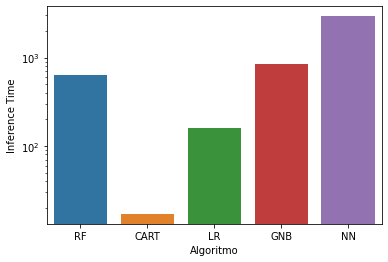

In [37]:
csv = read_csv("InfTimeReport.csv")
g = sbs.barplot(x=csv['Algoritmo'], y=csv['InfTime'])
g.set_yscale("log")
plt.ylabel("Inference Time")
plt.show()

# Memoria occupata

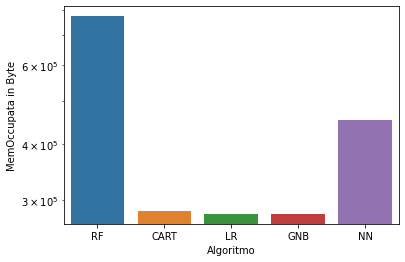

In [39]:
csv = read_csv("MemOccupationReport.csv")
g = sbs.barplot(x=csv['Algoritmo'], y=csv['MemOccupata'])
g.set_yscale('log')
plt.ylabel("MemOccupata in Byte")
plt.show()
# SVC in overflow